In [1]:
import sys
import torch
from torch.utils.data.dataset import Dataset
from torchvision import transforms
from PIL import Image
import pandas as pd

class MyLidcDatatset(Dataset):
    def __init__(self, IMAGES_PATHS, MASK_PATHS, image_size=512):
        """
        IMAGES_PATHS: list of images paths ['./..data_Image/Image/0001_NI000_slice000.png', 
        './..data_Image/Image/0001_NI000_slice001.png']

        MASKS_PATHS: list of masks paths ['./..data_Image/Mask/0001_MA000_slice000.png',
        './..data_Image/Mask/0001_MA000_slice001.png']
        """
        self.image_paths = IMAGES_PATHS
        self.mask_paths = MASK_PATHS
        self.image_size = image_size
        self.transformations = transforms.Compose([transforms.ToTensor()])

    def transform(self, image, mask):
        # output_image = Image.new("RGBA", (self.image_size, self.image_size))
        # output_image.paste(image, (0, 0))

        mask = mask.convert('L')
        image = image.convert('L')

        # image = self.transformations(output_image)
        # mask = self.transformations(mask)
        to_tensor = transforms.ToTensor()
        image = to_tensor(image)
        mask = to_tensor(mask)

        image = torch.cat((image,image,image,image), 0)

        image, mask = image.type(torch.FloatTensor), mask.type(torch.FloatTensor)

        return image, mask

    def adjust_dimensions(self, image, mask):
        if self.image_size == 512:
            return image, mask
        
        # image resize to the shape
        new_resolution = (self.image_size, self.image_size)
        resized_image = image.resize(new_resolution, Image.Resampling.LANCZOS)
        resized_mask = mask.resize(new_resolution, Image.Resampling.LANCZOS)
        
        return resized_image, resized_mask
        

    def __getitem__(self, index):
        cnt_try = 0
        # loop in case if there are any corrupted files
        while cnt_try < 10 and index < self.__len__():
            try:
                image = Image.open(self.image_paths[index])
                mask = Image.open(self.mask_paths[index])

                image, mask = self.adjust_dimensions(image, mask)

                image, mask = self.transform(image, mask)
                return image, mask, self.image_paths[index], self.mask_paths[index]
            
            except Exception as e:
                # if the image is corrupted, load the next image
                print("Corrupted file: ",
                      self.image_paths[index], '  |  ', sys.exc_info()[0])
                print(e)
                index += 1
                cnt_try += 1
        raise ("Could not resolve Corrupted file: ",
               self.image_paths[index], '  |  ', sys.exc_info()[0])

    def __len__(self):
        return len(self.image_paths)

def load_LIDC(image_size=512, combine_train_val=False, mode='Train'):
    # When the mode is Train, it'll load the dataset for training 
    # In case of mode being Test, it'll load the dataset for testing.
    # The combine_train_val indicates if we want to add tran set and validation set.
    # image_size will the resize the according to the python PIL image library.

    # Directory of Image, Mask folder
    IMAGE_DIR = './../data_Image/Image/'
    MASK_DIR = './../data_Image/Mask/'
    meta = pd.read_csv('./../data_Image/meta.csv')

    meta['original_image'] = meta['original_image'].apply(lambda x: (IMAGE_DIR) + x + '.png')
    meta['mask_image'] = meta['mask_image'].apply(lambda x: (MASK_DIR) + x + '.png')

    train_meta = meta[meta['data_split'] == 'Train']
    val_meta = meta[meta['data_split'] == 'Validation']

    if mode == 'Test':
        test_meta = meta[meta['data_split'] == 'Test']
        test_image_paths = list(test_meta['original_image'])
        test_mask_paths = list(test_meta['mask_image'])
        ds = MyLidcDatatset(test_image_paths, test_mask_paths, image_size)
        return ds
    
    # Get all *npy images into list for Train
    train_image_paths = list(train_meta['original_image'])
    train_mask_paths = list(train_meta['mask_image'])

    # Get all *npy images into list for Validation
    val_image_paths = list(val_meta['original_image'])
    val_mask_paths = list(val_meta['mask_image'])

    if combine_train_val:
        train_image_paths.extend(val_image_paths)
        train_mask_paths.extend(val_mask_paths)

        print("*"*50)
        print("The lenght of image: {}, mask folders: {} for train".format(
            len(train_image_paths), len(train_mask_paths)))
        print("*"*50)

        ds = MyLidcDatatset(train_image_paths, train_mask_paths, image_size)
        return ds

    # not combine train and val
    print("*"*50)
    print("The lenght of image: {}, mask folders: {} for train".format(
        len(train_image_paths), len(train_mask_paths)))
    print("The lenght of image: {}, mask folders: {} for validation".format(
        len(val_image_paths), len(val_mask_paths)))
    print("Ratio between Val/ Train is {:2f}".format(
        len(val_image_paths)/len(train_image_paths)))
    print("*"*50)

    # Create Dataset
    train_dataset = MyLidcDatatset(train_image_paths, train_mask_paths, image_size)
    val_dataset = MyLidcDatatset(val_image_paths, val_mask_paths, image_size)
    # test_dataset = MyLidcDataset(test_image_paths, test_mask_paths)

    return train_dataset, val_dataset

In [3]:
ds = load_LIDC(image_size=224, combine_train_val=True, mode='Test')

datal = torch.utils.data.DataLoader(
        ds,
        batch_size=1,
        shuffle=False)

data = iter(datal)
image, label, image_path, mask_paths = next(data)

# print(image.shape)
# print(label.shape)
len(data)

568

('./../data_Image/Image/0565_NI004_slice001.png',)


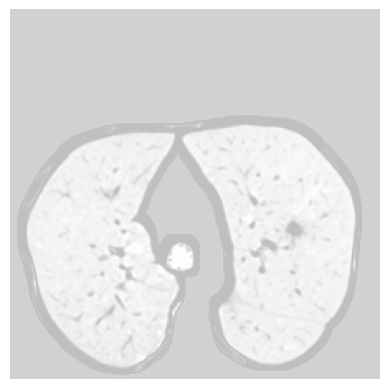

In [60]:
import matplotlib.pyplot as plt

to_pil = transforms.ToPILImage()

# Convert the tensor to a PIL Image
image = to_pil(image[0])
print(image_path)
# print(mask_path[0])
# Display the image using Matplotlib
plt.imshow(image)
plt.axis('off')  # Turn off axis labels
plt.show()


('./../data_Image/Image/0565_NI004_slice001.png',)


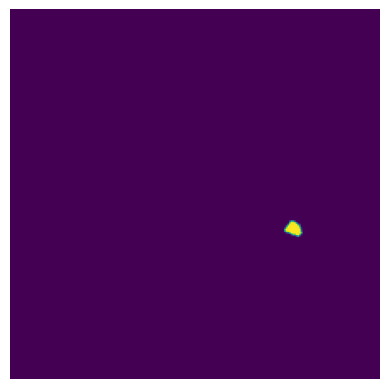

In [61]:
import matplotlib.pyplot as plt

to_pil = transforms.ToPILImage()

# Convert the tensor to a PIL Image
label = to_pil(label[0])
print(image_path)
# print(mask_path[0])
# Display the image using Matplotlib
plt.imshow(label)
plt.axis('off')  # Turn off axis labels
plt.show()


In [79]:
import torch
import matplotlib.pyplot as plt
from torchvision import transforms

def plot_tensors(tensor1, tensor2, tensor3, title):
    to_pil = transforms.ToPILImage()

    pil_image1 = to_pil(tensor1)
    pil_image2 = to_pil(tensor2)
    pil_image3 = to_pil(tensor3)

    # Plotting
    fig, axes = plt.subplots(1, 3, figsize=(12, 4))
    fig.suptitle(title, fontsize=14)

    axes[0].imshow(pil_image1)
    axes[0].set_title('Image', fontsize=10)

    axes[1].imshow(pil_image2)
    axes[1].set_title('Ground Truth', fontsize=10)

    axes[2].imshow(pil_image3)
    axes[2].set_title('Output', fontsize=10)

    for ax in axes:
        ax.axis('off')

    plt.savefig('./output_images/'+str(title)+'_output'+'.png')
    plt.show()

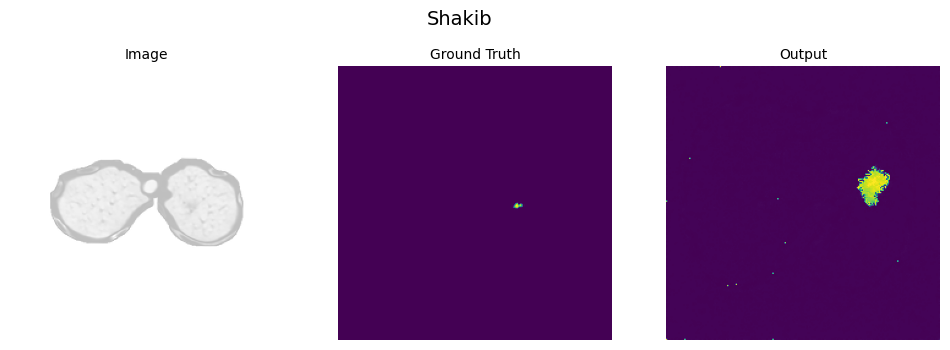

In [80]:
tensor1 = image[0]
tensor2 = label[0]
tensor3 = torch.load('./output/0194_NI001_slice001_output0').squeeze().cpu()
plot_tensors(tensor1, tensor2, tensor3, title='Shakib')

In [36]:
def dice_score(pred, targs):
    pred = (pred > 0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [37]:
tensor3 = torch.load('./output/0194_NI001_slice001_output0').squeeze().cpu()
print(tensor3.shape)
print(label[0].squeeze().cpu().shape)
k = dice_score(pred=tensor3, targs=label[0])
k

torch.Size([224, 224])
torch.Size([224, 224])


tensor(0.0048)

In [38]:
tmp = []
tmp.append(torch.load('./output/0194_NI001_slice001_output0').squeeze().cpu())
tmp.append(torch.load('./output/0194_NI001_slice001_output1').squeeze().cpu())
tmp.append(torch.load('./output/0194_NI001_slice001_output2').squeeze().cpu())
tmp.append(torch.load('./output/0194_NI001_slice001_output3').squeeze().cpu())

In [4]:
import pandas as pd
import os
import random

data = {'title': [], 'dice_score': [], 'ioU': [], 'hd95': []}
df = pd.DataFrame(data)

for i in range(5):
    title = f"Image_{i+1}"
    dice_score = random.uniform(0.5, 1.0) 
    new_row = pd.DataFrame([[title, dice_score]], 
                    columns=['title', 'dice_score'])
    
    df = pd.concat([df, new_row], ignore_index=True)

output_directory = 'metrics'
os.makedirs(output_directory, exist_ok=True)

output_file_path = os.path.join(output_directory, 'evaluation_metrics.csv')
df.to_csv(output_file_path, index=False)

print(f"DataFrame saved to: {output_file_path}")

Empty DataFrame
Columns: [title, dice_score]
Index: []
DataFrame saved to: metrics\evaluation_metrics.csv
